# Cylindrical Nanowire
I will use this notebook to model a cylindrical nanowire with $N_\phi$ points in $\phi$ direction and $N_z$ points along the z direction.

- BdG Hamiltonian will be used to incorporate superconductivity.

- An axial magnetic field will be assumed.

- Spin-orbit coupling and Zeeman splitting will be neglected.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import itertools
import scipy.optimize

# Define the Hamiltonian
The Hamiltonian will be a matrix of size $N_\phi N_z \times N_\phi N_z$. The order parameter and the chemical potential will be assumed to be constant in this region.

In [163]:
def calc_Hamiltonian(params):
    '''
    params is a dict with the following paramters:
    N_z   : number of points in z 
    N_phi : number of points in azimuthal direction
    t_z   : hopping paramter along z = hbar**2/(2 m a**2) where a is lattice spacing
    t_phi : hopping paramter along phi = hbar**2/(2 m a_phi**2) where a_phi is lattice spacing along 
            azimuthal direction 
    Delta : order paramter (complex number)
    mu    : chemical potential
    flux  : flux in units of h/e
    '''
    N_z = params['N_z'] 
    N_phi = params['N_phi'] 
    t_z = params['t_z']
    t_phi = params['t_phi']
    Delta = params['Delta']
    mu = params['mu']
    flux = params['flux']
    
    def matrix_ele(e1,e2):
        '''
        Returns the matrix element between points e1 and e2
        '''
        (z1,phi1) = e1
        (z2,phi2) = e2
        # onsite element
        if z1 == z2 and phi1 == phi2:
            if N_phi != 1:
                diag_ele = 2*t_z + np.abs(t_phi)*(2 - (2*np.pi*flux/N_phi)**2) - mu
            else:
                # diagonal elemenet for N_phi = 1 does not make sense
                diag_ele = 2*t_z - mu
            return np.array([[diag_ele,Delta],[np.conj(Delta),-np.conj(diag_ele)]])
        # z hopping
        elif abs(z1-z2) == 1 and phi1 == phi2:
            return np.array([[-t_z,0],[0,t_z]])
        # phi hopping
        elif (phi1-phi2 == 1 or phi1-phi2 == N_phi-1)and z1 == z2:
            return np.array([[-t_phi,0],[0,np.conj(t_phi)]])
        elif (phi1-phi2 == -1 or phi1-phi2 == -N_phi+1)and z1 == z2:
            return np.conj(np.array([[-t_phi,0],[0,np.conj(t_phi)]])).T
        else:
            return np.array([[0,0],[0,0]])
        
    # the basis is given by (n_z,n_phi) where n_z = 0,..,N_z-1, n_phi = 0,...,N_phi-1
    basis = list(itertools.product(range(N_z),range(N_phi)))
    H = [matrix_ele(e1,e2) for e1 in basis for e2 in basis]
    N = N_phi*N_z

    H_ar = np.array(H,dtype=np.complex64).reshape((N,N,2,2))
    
    # magic to flatten the Hamiltonian
    # Are you wathing closely?
    H_mat = np.array([H_ar[x,:,y,:].flatten() for x in range(H_ar.shape[0]) for y in range(H_ar.shape[2])])\
    .flatten().reshape(2*N,2*N)

    return H_mat

In [8]:
# test of the Hamiltonian function
params = {
    "N_z" : 2,
    "N_phi" : 2,
    "flux" : 0e0,
    "t_z" : 5e-3,
    "Delta" : 1e-3,
    "mu" : 10e-3,
}

params["t_phi"] = 5e-3*np.exp(1j*2*np.pi*params["flux"]/params["N_phi"])

H = calc_Hamiltonian(params)
print(H)

[[ 0.020+0.j  0.001+0.j -0.010+0.j  0.000-0.j -0.005+0.j  0.000+0.j
   0.000+0.j  0.000+0.j]
 [ 0.001+0.j -0.020+0.j  0.000-0.j  0.010+0.j  0.000+0.j  0.005+0.j
   0.000+0.j  0.000+0.j]
 [-0.010-0.j  0.000+0.j  0.020+0.j  0.001+0.j  0.000+0.j  0.000+0.j
  -0.005+0.j  0.000+0.j]
 [ 0.000+0.j  0.010-0.j  0.001+0.j -0.020+0.j  0.000+0.j  0.000+0.j
   0.000+0.j  0.005+0.j]
 [-0.005+0.j  0.000+0.j  0.000+0.j  0.000+0.j  0.020+0.j  0.001+0.j
  -0.010+0.j  0.000-0.j]
 [ 0.000+0.j  0.005+0.j  0.000+0.j  0.000+0.j  0.001+0.j -0.020+0.j
   0.000-0.j  0.010+0.j]
 [ 0.000+0.j  0.000+0.j -0.005+0.j  0.000+0.j -0.010-0.j  0.000+0.j
   0.020+0.j  0.001+0.j]
 [ 0.000+0.j  0.000+0.j  0.000+0.j  0.005+0.j  0.000+0.j  0.010-0.j
   0.001+0.j -0.020+0.j]]


# Density of States Calculation
I will define a function to calculate the density of states given a Hamiltonian.

In [12]:
def calc_dos(E,params):
    '''
    Returns the density of states for the Hamiltonian H for energies E
    '''
    H = calc_Hamiltonian(params)
    
    eta = params['eta']
    G = np.linalg.inv((E + 1j*eta).reshape(-1,1,1)*np.eye(H.shape[0]).reshape(1,H.shape[0],H.shape[1]) - H)
    A = 1j*(G - np.transpose(np.conj(G),(0,2,1)))
    # casting to real done to avoid problems later with plotting
    a = np.real(np.trace(A,axis1=-1,axis2=-2))
    return a

In [194]:
params = {
    "N_z" : 100,
    "N_phi" : 2,
    "flux" : 0e0,
    "t_z" : 50e-3,
    "Delta" : 1e-3,
    "mu" : 0e-3,
}

params["t_phi"] = 50e-3*np.exp(1j*2*np.pi*params["flux"]/params["N_phi"])

E_vec = np.linspace(-params['mu'],params['mu'],1000)
eta = 1*(E_vec[1] - E_vec[0])
params['eta'] = eta
dos_vec = calc_dos(E_vec,params)
E_vec_gap = np.linspace(-2*params['Delta'],2*params['Delta'],100)
eta = 1*(E_vec_gap[1] - E_vec_gap[0])
params['eta'] = eta
dos_vec_gap = calc_dos(E_vec_gap,params)

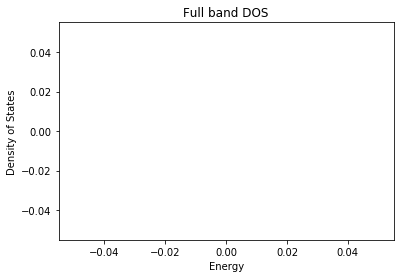

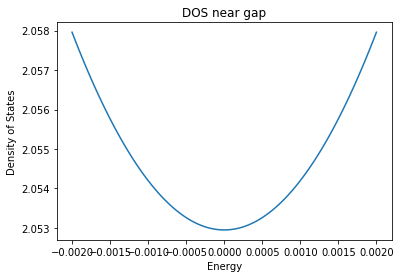

In [195]:
plt.figure(1)
plt.plot(E_vec,dos_vec)
plt.xlabel('Energy')
plt.ylabel('Density of States')
plt.title("Full band DOS")
plt.figure(2)
plt.plot(E_vec_gap,dos_vec_gap)
plt.xlabel('Energy')
plt.ylabel('Density of States')
plt.title("DOS near gap")

## Effect of changing mu

In [196]:
mu_vec = np.linspace(0,400e-3,50)
# the range has to set to maximum of mu possible
# to see all dos
E_vec = np.linspace(-200e-3,200e-3,500)
E_vec_gap = np.linspace(-2*params['Delta'],2*params['Delta'],500)

dos_array = []
dos_gap_array = []
for mu in mu_vec:
    print(mu)
    params['mu'] = mu
    
    eta = 1*(E_vec[1] - E_vec[0])
    params['eta'] = eta
    dos_vec = calc_dos(E_vec,params)
    dos_array.append(dos_vec)
    
    eta = 1*(E_vec_gap[1] - E_vec_gap[0])
    params['eta'] = eta
    dos_vec_gap = calc_dos(E_vec_gap,params)
    dos_gap_array.append(dos_vec_gap)

0.0
0.00816326530612
0.0163265306122
0.0244897959184
0.0326530612245
0.0408163265306
0.0489795918367
0.0571428571429
0.065306122449
0.0734693877551
0.0816326530612
0.0897959183673
0.0979591836735
0.10612244898
0.114285714286
0.122448979592
0.130612244898
0.138775510204
0.14693877551
0.155102040816
0.163265306122
0.171428571429
0.179591836735
0.187755102041
0.195918367347
0.204081632653
0.212244897959
0.220408163265
0.228571428571
0.236734693878
0.244897959184
0.25306122449
0.261224489796
0.269387755102
0.277551020408
0.285714285714
0.29387755102
0.302040816327
0.310204081633
0.318367346939
0.326530612245
0.334693877551
0.342857142857
0.351020408163
0.359183673469
0.367346938776
0.375510204082
0.383673469388
0.391836734694
0.4


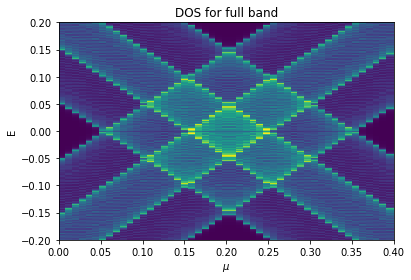

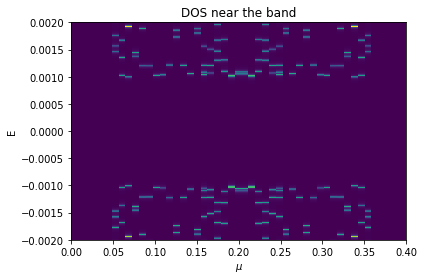

In [197]:
plt.figure(1)
XX,YY = np.meshgrid(mu_vec,E_vec)
plt.pcolor(XX,YY,np.array(dos_array).T)
plt.xlabel("$\mu$")
plt.ylabel("E")
plt.title("DOS for full band")

plt.figure(2)
XX,YY = np.meshgrid(mu_vec,E_vec_gap)
plt.pcolor(XX,YY,np.array(dos_gap_array).T)
plt.xlabel("$\mu$")
plt.ylabel("E")
plt.title("DOS near the band")